In [20]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import deepxde as dde
from mpl_toolkits import mplot3d
import numpy as np
import sys
print(sys.executable)


# 用于绘图


D:\anaconda\python.exe


In [21]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import deepxde as dde
from mpl_toolkits import mplot3d
import numpy as np
import sys
print(sys.executable)


# 用于绘图


print(sys.executable)
# 周期性边界条件
x_lower = -5*np.pi
x_upper = 5*np.pi
t_lower = -2
t_upper = 2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分

a=2
b=3
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """

    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    # f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    # f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    a=2
    b=3
    r1 = 2
    r2 = 4
    r3 = -2
    r4=4*a*b/(a**2+b**2)
    beta = 1

    f_u1 = (
        v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2 **2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
        -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2 **2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
        v2_t + beta*u2_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1 **2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
        -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1 **2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )

    return [
        f_u1, f_v1, f_u2, f_v2,
        # f_u1x, f_u1t,
        # f_v1x, f_v1t,
        # f_u2x, f_u2t,
        # f_v2x, f_v2t
    ]
 # 边界条件和初始条件


# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
# (e^c=...)
# 初始条件


def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)



# q_111=q1` q_1=q1 q_11=q1*


def init_cond_u1(x):
    i = 0+1j
    delta1=((2 + np.sqrt(2))*(x[:,0:1]**2) + 4*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) 
            - 8*i*(3 + 2*np.sqrt(2))*(x[:,0:1]**2)*x[:,1:2]
            +8*(8*(3 + 2*np.sqrt(2))*(x[:,0:1]**2) - 2 - np.sqrt(2))*(x[:,1:2]**2) 
            - 64*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 256*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
           )

    delta2=( -np.sqrt(2) - 2*np.sqrt(2)*(x[:,0:1]**2) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) 
            - 8*i*(1 + np.sqrt(2) + (6+4*np.sqrt(2))*(x[:,0:1]**2))*x[:,1:2] 
            + 16*(np.sqrt(2) + 24*(x[:,0:1]**2) + 16*np.sqrt(2)*(x[:,0:1]**2))*(x[:,1:2]**2)
            -128*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
    )
    
    delta0=(1+ 32*(1+np.sqrt(2))*(x[:,1:2]**2) + 4*(2+np.sqrt(2))*(x[:,0:1]**2) 
            +128*(3 + 2*np.sqrt(2))*(x[:,1:2]**2)*(x[:,0:1]**2)
            +512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4)
    )
    
    Q1=np.exp(4*i*x[:,1:2])*(1-4*delta1/delta0)
    
    Q2=np.exp(4*i*x[:,1:2])*(1-2*delta2/delta0)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2

    result = q1.real



    # result=( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #      )
    return result


def init_cond_u2(x):
    i = 0+1j
    delta1=((2 + np.sqrt(2))*(x[:,0:1]**2) + 4*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) - 8*i*(3 + 2*np.sqrt(2))*(x[:,0:1]**2)*x[:,1:2]
            +8*(8*(3 + 2*np.sqrt(2))*(x[:,0:1]**2) - 2 - np.sqrt(2))*(x[:,1:2]**2) 
            - 64*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 256*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
           )

    delta2=( -np.sqrt(2) - 2*np.sqrt(2)*(x[:,0:1]**2) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) 
            - 8*i*(1 + np.sqrt(2) + (6+4*np.sqrt(2))*(x[:,0:1]**2))*x[:,1:2] 
            + 16*(np.sqrt(2) + 24*(x[:,0:1]**2) + 16*np.sqrt(2)*(x[:,0:1]**2))*(x[:,1:2]**2)
            -128*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
    )
    
    delta0=(1+ 32*(1+np.sqrt(2))*(x[:,1:2]**2) + 4*(2+np.sqrt(2))*(x[:,0:1]**2) +128*(3 + 2*np.sqrt(2))*(x[:,1:2]**2)*(x[:,0:1]**2)
            +512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4)
    
    )
    
    Q1=np.exp(4*i*x[:,1:2])*(1-4*delta1/delta0)
    Q2=np.exp(4*i*x[:,1:2])*(1-2*delta2/delta0)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    result = q2.real



    # result=( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #     )
    return result


def init_cond_v1(x):
    i = 0+1j
    delta1=((2 + np.sqrt(2))*(x[:,0:1]**2) + 4*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) - 8*i*(3 + 2*np.sqrt(2))*(x[:,0:1]**2)*x[:,1:2]
            +8*(8*(3 + 2*np.sqrt(2))*(x[:,0:1]**2) - 2 - np.sqrt(2))*(x[:,1:2]**2) 
            - 64*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 256*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
           )

    delta2=( -np.sqrt(2) - 2*np.sqrt(2)*(x[:,0:1]**2) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) 
            - 8*i*(1 + np.sqrt(2) + (6+4*np.sqrt(2))*(x[:,0:1]**2))*x[:,1:2] 
            + 16*(np.sqrt(2) + 24*(x[:,0:1]**2) + 16*np.sqrt(2)*(x[:,0:1]**2))*(x[:,1:2]**2)
            -128*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
    )
    
    delta0=(1+ 32*(1+np.sqrt(2))*(x[:,1:2]**2) + 4*(2+np.sqrt(2))*(x[:,0:1]**2) +128*(3 + 2*np.sqrt(2))*(x[:,1:2]**2)*(x[:,0:1]**2)
            +512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4)
    
    )
    
    Q1=np.exp(4*i*x[:,1:2])*(1-4*delta1/delta0)
    Q2=np.exp(4*i*x[:,1:2])*(1-2*delta2/delta0)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    result= -q1.imag

    # result=-( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result


def init_cond_v2(x):
    i = 0+1j
    delta1=((2 + np.sqrt(2))*(x[:,0:1]**2) + 4*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) - 8*i*(3 + 2*np.sqrt(2))*(x[:,0:1]**2)*x[:,1:2]
            +8*(8*(3 + 2*np.sqrt(2))*(x[:,0:1]**2) - 2 - np.sqrt(2))*(x[:,1:2]**2) 
            - 64*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 256*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
           )

    delta2=( -np.sqrt(2) - 2*np.sqrt(2)*(x[:,0:1]**2) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4) 
            - 8*i*(1 + np.sqrt(2) + (6+4*np.sqrt(2))*(x[:,0:1]**2))*x[:,1:2] 
            + 16*(np.sqrt(2) + 24*(x[:,0:1]**2) + 16*np.sqrt(2)*(x[:,0:1]**2))*(x[:,1:2]**2)
            -128*i*(3 + 2*np.sqrt(2))*(x[:,1:2]**3) + 512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4)
    )
    
    delta0=(1+ 32*(1+np.sqrt(2))*(x[:,1:2]**2) + 4*(2+np.sqrt(2))*(x[:,0:1]**2) +128*(3 + 2*np.sqrt(2))*(x[:,1:2]**2)*(x[:,0:1]**2)
            +512*(3 + 2*np.sqrt(2))*(x[:,1:2]**4) + 8*(3 + 2*np.sqrt(2))*(x[:,0:1]**4)
    )
    
    Q1=np.exp(4*i*x[:,1:2])*(1-4*delta1/delta0)
    Q2=np.exp(4*i*x[:,1:2])*(1-2*delta2/delta0)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2

    result = -q2.imag

    # result= ( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result


ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1, bc_u2_0, bc_u2_1,
        bc_v2_0, bc_v2_1, ic_u1, ic_v1, ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=200,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused = True
# 网络架构
net = dde.maps.FNN([2] + [100] * 6 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)


D:\anaconda\python.exe
D:\anaconda\python.exe


In [22]:
model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=6000, display_every=10)


Compiling model...
Building feed-forward neural network...
'build' took 0.109903 s

'compile' took 9.228296 s

Initializing variables...
Training model...

0         [4.36e-06, 1.21e-04, 1.53e-05, 1.82e-05, 1.33e-02, 2.51e-04, 4.79e-02, 9.65e-06, 2.73e-03, 1.42e-04, 7.41e-03, 3.64e-04, 1.43e-03, 4.13e-02, 6.50e-04, 4.27e-02]    [4.36e-06, 1.21e-04, 1.53e-05, 1.82e-05, 1.33e-02, 2.51e-04, 4.79e-02, 9.65e-06, 2.73e-03, 1.42e-04, 7.41e-03, 3.64e-04, 1.43e-03, 4.13e-02, 6.50e-04, 4.27e-02]    []  
10        [3.76e-04, 1.85e-03, 1.72e-04, 1.55e-03, 1.72e-04, 2.85e-05, 1.53e-03, 2.24e-04, 3.03e-04, 1.33e-06, 6.15e-04, 1.27e-03, 1.89e-04, 4.76e-03, 1.62e-04, 6.69e-03]    [3.76e-04, 1.85e-03, 1.72e-04, 1.55e-03, 1.72e-04, 2.85e-05, 1.53e-03, 2.24e-04, 3.03e-04, 1.33e-06, 6.15e-04, 1.27e-03, 1.89e-04, 4.76e-03, 1.62e-04, 6.69e-03]    []  
20        [2.81e-04, 6.83e-04, 1.71e-04, 2.93e-04, 2.00e-04, 1.01e-04, 4.02e-05, 8.78e-05, 3.99e-04, 1.50e-06, 3.87e-05, 1.43e-05, 2.69e-04, 8.10e-04, 1.93e-0

240       [4.31e-05, 1.96e-05, 5.60e-05, 1.54e-05, 9.45e-08, 2.90e-06, 6.78e-07, 9.74e-07, 2.74e-07, 1.44e-07, 8.21e-08, 2.22e-06, 3.23e-06, 6.23e-06, 5.34e-06, 4.62e-06]    [4.31e-05, 1.96e-05, 5.60e-05, 1.54e-05, 9.45e-08, 2.90e-06, 6.78e-07, 9.74e-07, 2.74e-07, 1.44e-07, 8.21e-08, 2.22e-06, 3.23e-06, 6.23e-06, 5.34e-06, 4.62e-06]    []  
250       [4.00e-05, 1.73e-05, 5.34e-05, 1.46e-05, 8.10e-08, 2.76e-06, 6.77e-07, 9.64e-07, 2.32e-07, 1.54e-07, 7.11e-08, 2.14e-06, 3.11e-06, 5.81e-06, 5.14e-06, 4.27e-06]    [4.00e-05, 1.73e-05, 5.34e-05, 1.46e-05, 8.10e-08, 2.76e-06, 6.77e-07, 9.64e-07, 2.32e-07, 1.54e-07, 7.11e-08, 2.14e-06, 3.11e-06, 5.81e-06, 5.14e-06, 4.27e-06]    []  
260       [3.70e-05, 1.53e-05, 5.07e-05, 1.39e-05, 7.50e-08, 2.62e-06, 6.77e-07, 9.53e-07, 1.96e-07, 1.63e-07, 6.16e-08, 2.07e-06, 3.01e-06, 5.40e-06, 4.95e-06, 3.93e-06]    [3.70e-05, 1.53e-05, 5.07e-05, 1.39e-05, 7.50e-08, 2.62e-06, 6.77e-07, 9.53e-07, 1.96e-07, 1.63e-07, 6.16e-08, 2.07e-06, 3.01e-06, 5.40e-06,

480       [1.31e-06, 2.14e-06, 2.89e-06, 1.37e-06, 8.42e-08, 2.85e-07, 1.61e-07, 2.76e-07, 4.16e-08, 3.31e-07, 2.85e-08, 5.79e-07, 1.80e-06, 8.45e-07, 2.40e-06, 3.02e-07]    [1.31e-06, 2.14e-06, 2.89e-06, 1.37e-06, 8.42e-08, 2.85e-07, 1.61e-07, 2.76e-07, 4.16e-08, 3.31e-07, 2.85e-08, 5.79e-07, 1.80e-06, 8.45e-07, 2.40e-06, 3.02e-07]    []  
490       [1.20e-06, 2.13e-06, 2.58e-06, 1.28e-06, 7.82e-08, 2.33e-07, 1.39e-07, 2.53e-07, 4.15e-08, 3.13e-07, 2.74e-08, 5.25e-07, 1.77e-06, 8.19e-07, 2.35e-06, 2.94e-07]    [1.20e-06, 2.13e-06, 2.58e-06, 1.28e-06, 7.82e-08, 2.33e-07, 1.39e-07, 2.53e-07, 4.15e-08, 3.13e-07, 2.74e-08, 5.25e-07, 1.77e-06, 8.19e-07, 2.35e-06, 2.94e-07]    []  
500       [1.13e-06, 2.11e-06, 2.33e-06, 1.21e-06, 7.31e-08, 1.89e-07, 1.21e-07, 2.31e-07, 4.13e-08, 2.94e-07, 2.64e-08, 4.75e-07, 1.73e-06, 7.95e-07, 2.30e-06, 2.89e-07]    [1.13e-06, 2.11e-06, 2.33e-06, 1.21e-06, 7.31e-08, 1.89e-07, 1.21e-07, 2.31e-07, 4.13e-08, 2.94e-07, 2.64e-08, 4.75e-07, 1.73e-06, 7.95e-07,

720       [1.17e-06, 1.53e-06, 1.13e-06, 7.72e-07, 2.03e-05, 3.38e-08, 1.90e-06, 4.90e-08, 1.16e-06, 7.37e-08, 7.83e-07, 4.37e-08, 3.46e-06, 7.93e-07, 1.71e-06, 3.49e-07]    [1.17e-06, 1.53e-06, 1.13e-06, 7.72e-07, 2.03e-05, 3.38e-08, 1.90e-06, 4.90e-08, 1.16e-06, 7.37e-08, 7.83e-07, 4.37e-08, 3.46e-06, 7.93e-07, 1.71e-06, 3.49e-07]    []  
730       [9.18e-07, 1.38e-06, 1.06e-06, 6.24e-07, 4.99e-06, 4.41e-08, 4.78e-07, 6.46e-08, 3.22e-07, 5.76e-08, 1.99e-07, 6.39e-08, 1.72e-06, 5.85e-07, 1.62e-06, 2.19e-07]    [9.18e-07, 1.38e-06, 1.06e-06, 6.24e-07, 4.99e-06, 4.41e-08, 4.78e-07, 6.46e-08, 3.22e-07, 5.76e-08, 1.99e-07, 6.39e-08, 1.72e-06, 5.85e-07, 1.62e-06, 2.19e-07]    []  
740       [8.22e-07, 1.33e-06, 1.04e-06, 5.82e-07, 1.71e-06, 3.21e-08, 1.86e-07, 4.33e-08, 1.32e-07, 4.59e-08, 7.51e-08, 4.89e-08, 1.36e-06, 5.63e-07, 1.57e-06, 1.96e-07]    [8.22e-07, 1.33e-06, 1.04e-06, 5.82e-07, 1.71e-06, 3.21e-08, 1.86e-07, 4.33e-08, 1.32e-07, 4.59e-08, 7.51e-08, 4.89e-08, 1.36e-06, 5.63e-07,

960       [5.85e-07, 8.42e-07, 6.35e-07, 3.32e-07, 2.85e-08, 7.14e-08, 1.46e-08, 3.17e-08, 2.60e-08, 3.29e-08, 1.69e-08, 1.53e-08, 9.53e-07, 4.92e-07, 1.28e-06, 1.28e-07]    [5.85e-07, 8.42e-07, 6.35e-07, 3.32e-07, 2.85e-08, 7.14e-08, 1.46e-08, 3.17e-08, 2.60e-08, 3.29e-08, 1.69e-08, 1.53e-08, 9.53e-07, 4.92e-07, 1.28e-06, 1.28e-07]    []  
970       [5.75e-07, 8.35e-07, 6.18e-07, 3.29e-07, 4.85e-08, 7.54e-08, 1.56e-08, 2.93e-08, 2.74e-08, 3.26e-08, 1.69e-08, 1.63e-08, 9.45e-07, 4.86e-07, 1.27e-06, 1.25e-07]    [5.75e-07, 8.35e-07, 6.18e-07, 3.29e-07, 4.85e-08, 7.54e-08, 1.56e-08, 2.93e-08, 2.74e-08, 3.26e-08, 1.69e-08, 1.63e-08, 9.45e-07, 4.86e-07, 1.27e-06, 1.25e-07]    []  
980       [5.66e-07, 8.22e-07, 5.99e-07, 3.25e-07, 2.82e-08, 8.07e-08, 1.33e-08, 2.89e-08, 2.48e-08, 3.22e-08, 1.66e-08, 1.53e-08, 9.25e-07, 4.82e-07, 1.26e-06, 1.24e-07]    [5.66e-07, 8.22e-07, 5.99e-07, 3.25e-07, 2.82e-08, 8.07e-08, 1.33e-08, 2.89e-08, 2.48e-08, 3.22e-08, 1.66e-08, 1.53e-08, 9.25e-07, 4.82e-07,

1200      [1.29e-06, 8.90e-07, 4.22e-07, 6.40e-07, 8.09e-05, 1.32e-07, 5.07e-06, 3.61e-08, 1.13e-05, 2.41e-08, 1.50e-06, 2.27e-08, 8.13e-06, 1.49e-06, 2.07e-06, 4.59e-07]    [1.29e-06, 8.90e-07, 4.22e-07, 6.40e-07, 8.09e-05, 1.32e-07, 5.07e-06, 3.61e-08, 1.13e-05, 2.41e-08, 1.50e-06, 2.27e-08, 8.13e-06, 1.49e-06, 2.07e-06, 4.59e-07]    []  
1210      [9.69e-07, 1.10e-06, 4.61e-07, 4.79e-07, 3.41e-07, 1.78e-07, 3.29e-08, 4.12e-08, 3.98e-07, 1.50e-07, 4.25e-08, 1.60e-08, 1.16e-06, 5.83e-07, 1.13e-06, 3.18e-07]    [9.69e-07, 1.10e-06, 4.61e-07, 4.79e-07, 3.41e-07, 1.78e-07, 3.29e-08, 4.12e-08, 3.98e-07, 1.50e-07, 4.25e-08, 1.60e-08, 1.16e-06, 5.83e-07, 1.13e-06, 3.18e-07]    []  
1220      [7.97e-07, 8.24e-07, 4.31e-07, 3.05e-07, 2.99e-06, 1.37e-07, 1.64e-07, 1.33e-07, 6.20e-06, 4.94e-08, 7.06e-07, 9.16e-08, 1.01e-06, 5.07e-07, 1.48e-06, 1.48e-07]    [7.97e-07, 8.24e-07, 4.31e-07, 3.05e-07, 2.99e-06, 1.37e-07, 1.64e-07, 1.33e-07, 6.20e-06, 4.94e-08, 7.06e-07, 9.16e-08, 1.01e-06, 5.07e-07,

1440      [3.49e-07, 3.62e-07, 2.64e-07, 1.74e-07, 1.35e-08, 9.33e-08, 2.21e-09, 3.05e-08, 1.27e-08, 4.59e-08, 1.05e-08, 2.15e-08, 6.25e-07, 3.25e-07, 9.31e-07, 9.03e-08]    [3.49e-07, 3.62e-07, 2.64e-07, 1.74e-07, 1.35e-08, 9.33e-08, 2.21e-09, 3.05e-08, 1.27e-08, 4.59e-08, 1.05e-08, 2.15e-08, 6.25e-07, 3.25e-07, 9.31e-07, 9.03e-08]    []  
1450      [3.46e-07, 3.56e-07, 2.61e-07, 1.73e-07, 1.33e-08, 9.30e-08, 2.11e-09, 3.06e-08, 1.25e-08, 4.61e-08, 1.03e-08, 2.18e-08, 6.19e-07, 3.22e-07, 9.24e-07, 9.00e-08]    [3.46e-07, 3.56e-07, 2.61e-07, 1.73e-07, 1.33e-08, 9.30e-08, 2.11e-09, 3.06e-08, 1.25e-08, 4.61e-08, 1.03e-08, 2.18e-08, 6.19e-07, 3.22e-07, 9.24e-07, 9.00e-08]    []  
1460      [3.43e-07, 3.51e-07, 2.59e-07, 1.71e-07, 1.31e-08, 9.26e-08, 2.02e-09, 3.06e-08, 1.23e-08, 4.63e-08, 1.01e-08, 2.21e-08, 6.13e-07, 3.20e-07, 9.17e-07, 8.96e-08]    [3.43e-07, 3.51e-07, 2.59e-07, 1.71e-07, 1.31e-08, 9.26e-08, 2.02e-09, 3.06e-08, 1.23e-08, 4.63e-08, 1.01e-08, 2.21e-08, 6.13e-07, 3.20e-07,

1680      [2.99e-07, 2.47e-07, 2.03e-07, 1.52e-07, 1.08e-08, 6.01e-08, 1.23e-09, 3.35e-08, 1.40e-08, 2.92e-08, 8.38e-09, 2.38e-08, 5.44e-07, 2.69e-07, 8.59e-07, 8.74e-08]    [2.99e-07, 2.47e-07, 2.03e-07, 1.52e-07, 1.08e-08, 6.01e-08, 1.23e-09, 3.35e-08, 1.40e-08, 2.92e-08, 8.38e-09, 2.38e-08, 5.44e-07, 2.69e-07, 8.59e-07, 8.74e-08]    []  
1690      [2.97e-07, 2.47e-07, 2.02e-07, 1.52e-07, 9.27e-09, 6.17e-08, 1.51e-09, 3.39e-08, 1.04e-08, 2.97e-08, 7.89e-09, 2.41e-08, 5.35e-07, 2.66e-07, 8.49e-07, 8.72e-08]    [2.97e-07, 2.47e-07, 2.02e-07, 1.52e-07, 9.27e-09, 6.17e-08, 1.51e-09, 3.39e-08, 1.04e-08, 2.97e-08, 7.89e-09, 2.41e-08, 5.35e-07, 2.66e-07, 8.49e-07, 8.72e-08]    []  
1700      [2.94e-07, 2.46e-07, 2.01e-07, 1.52e-07, 9.10e-09, 6.28e-08, 1.58e-09, 3.41e-08, 1.02e-08, 3.10e-08, 7.76e-09, 2.44e-08, 5.27e-07, 2.63e-07, 8.39e-07, 8.70e-08]    [2.94e-07, 2.46e-07, 2.01e-07, 1.52e-07, 9.10e-09, 6.28e-08, 1.58e-09, 3.41e-08, 1.02e-08, 3.10e-08, 7.76e-09, 2.44e-08, 5.27e-07, 2.63e-07,

1920      [2.94e-07, 2.15e-07, 1.79e-07, 1.55e-07, 1.66e-08, 5.31e-08, 8.31e-09, 3.57e-08, 1.40e-08, 3.48e-08, 8.40e-09, 2.29e-08, 4.46e-07, 2.14e-07, 6.90e-07, 8.31e-08]    [2.94e-07, 2.15e-07, 1.79e-07, 1.55e-07, 1.66e-08, 5.31e-08, 8.31e-09, 3.57e-08, 1.40e-08, 3.48e-08, 8.40e-09, 2.29e-08, 4.46e-07, 2.14e-07, 6.90e-07, 8.31e-08]    []  
1930      [2.87e-07, 2.14e-07, 1.78e-07, 1.56e-07, 7.29e-09, 5.43e-08, 6.37e-09, 3.66e-08, 1.52e-08, 3.55e-08, 9.40e-09, 2.33e-08, 4.38e-07, 2.11e-07, 6.79e-07, 8.30e-08]    [2.87e-07, 2.14e-07, 1.78e-07, 1.56e-07, 7.29e-09, 5.43e-08, 6.37e-09, 3.66e-08, 1.52e-08, 3.55e-08, 9.40e-09, 2.33e-08, 4.38e-07, 2.11e-07, 6.79e-07, 8.30e-08]    []  
1940      [2.84e-07, 2.13e-07, 1.74e-07, 1.55e-07, 8.95e-09, 5.63e-08, 3.72e-09, 3.63e-08, 1.14e-08, 3.54e-08, 7.33e-09, 2.36e-08, 4.24e-07, 2.09e-07, 6.74e-07, 8.39e-08]    [2.84e-07, 2.13e-07, 1.74e-07, 1.55e-07, 8.95e-09, 5.63e-08, 3.72e-09, 3.63e-08, 1.14e-08, 3.54e-08, 7.33e-09, 2.36e-08, 4.24e-07, 2.09e-07,

2160      [2.48e-07, 1.98e-07, 1.64e-07, 1.60e-07, 5.43e-09, 4.46e-08, 2.47e-09, 3.05e-08, 8.56e-09, 2.69e-08, 3.78e-09, 2.58e-08, 3.45e-07, 1.66e-07, 5.98e-07, 8.15e-08]    [2.48e-07, 1.98e-07, 1.64e-07, 1.60e-07, 5.43e-09, 4.46e-08, 2.47e-09, 3.05e-08, 8.56e-09, 2.69e-08, 3.78e-09, 2.58e-08, 3.45e-07, 1.66e-07, 5.98e-07, 8.15e-08]    []  
2170      [2.47e-07, 1.98e-07, 1.63e-07, 1.60e-07, 5.33e-09, 4.49e-08, 2.53e-09, 3.00e-08, 8.42e-09, 2.77e-08, 3.63e-09, 2.60e-08, 3.40e-07, 1.65e-07, 5.90e-07, 8.12e-08]    [2.47e-07, 1.98e-07, 1.63e-07, 1.60e-07, 5.33e-09, 4.49e-08, 2.53e-09, 3.00e-08, 8.42e-09, 2.77e-08, 3.63e-09, 2.60e-08, 3.40e-07, 1.65e-07, 5.90e-07, 8.12e-08]    []  
2180      [2.46e-07, 1.99e-07, 1.63e-07, 1.61e-07, 5.31e-09, 4.50e-08, 2.58e-09, 2.94e-08, 8.45e-09, 2.85e-08, 3.50e-09, 2.63e-08, 3.34e-07, 1.63e-07, 5.82e-07, 8.10e-08]    [2.46e-07, 1.99e-07, 1.63e-07, 1.61e-07, 5.31e-09, 4.50e-08, 2.58e-09, 2.94e-08, 8.45e-09, 2.85e-08, 3.50e-09, 2.63e-08, 3.34e-07, 1.63e-07,

2400      [2.42e-07, 1.80e-07, 1.57e-07, 1.60e-07, 2.45e-08, 2.68e-08, 8.40e-09, 2.41e-08, 4.00e-08, 1.50e-08, 1.02e-08, 2.54e-08, 3.02e-07, 1.31e-07, 5.43e-07, 7.95e-08]    [2.42e-07, 1.80e-07, 1.57e-07, 1.60e-07, 2.45e-08, 2.68e-08, 8.40e-09, 2.41e-08, 4.00e-08, 1.50e-08, 1.02e-08, 2.54e-08, 3.02e-07, 1.31e-07, 5.43e-07, 7.95e-08]    []  
2410      [2.35e-07, 1.83e-07, 1.56e-07, 1.62e-07, 2.20e-08, 2.72e-08, 2.88e-09, 2.44e-08, 1.97e-08, 1.60e-08, 3.15e-09, 2.45e-08, 2.94e-07, 1.28e-07, 5.30e-07, 8.03e-08]    [2.35e-07, 1.83e-07, 1.56e-07, 1.62e-07, 2.20e-08, 2.72e-08, 2.88e-09, 2.44e-08, 1.97e-08, 1.60e-08, 3.15e-09, 2.45e-08, 2.94e-07, 1.28e-07, 5.30e-07, 8.03e-08]    []  
2420      [2.30e-07, 1.87e-07, 1.55e-07, 1.63e-07, 5.50e-09, 2.86e-08, 2.84e-09, 2.45e-08, 1.11e-08, 1.72e-08, 2.57e-09, 2.51e-08, 2.84e-07, 1.27e-07, 5.20e-07, 7.93e-08]    [2.30e-07, 1.87e-07, 1.55e-07, 1.63e-07, 5.50e-09, 2.86e-08, 2.84e-09, 2.45e-08, 1.11e-08, 1.72e-08, 2.57e-09, 2.51e-08, 2.84e-07, 1.27e-07,

2640      [2.07e-07, 1.94e-07, 1.48e-07, 1.67e-07, 1.97e-07, 3.03e-08, 1.85e-08, 1.51e-08, 2.07e-07, 2.62e-08, 2.93e-08, 2.49e-08, 2.22e-07, 9.70e-08, 4.14e-07, 7.17e-08]    [2.07e-07, 1.94e-07, 1.48e-07, 1.67e-07, 1.97e-07, 3.03e-08, 1.85e-08, 1.51e-08, 2.07e-07, 2.62e-08, 2.93e-08, 2.49e-08, 2.22e-07, 9.70e-08, 4.14e-07, 7.17e-08]    []  
2650      [2.08e-07, 1.93e-07, 1.59e-07, 1.69e-07, 3.82e-06, 3.00e-08, 3.22e-07, 1.48e-08, 4.24e-06, 3.07e-08, 5.81e-07, 2.52e-08, 5.93e-07, 9.96e-08, 8.39e-07, 7.27e-08]    [2.08e-07, 1.93e-07, 1.59e-07, 1.69e-07, 3.82e-06, 3.00e-08, 3.22e-07, 1.48e-08, 4.24e-06, 3.07e-08, 5.81e-07, 2.52e-08, 5.93e-07, 9.96e-08, 8.39e-07, 7.27e-08]    []  
2660      [2.58e-07, 3.17e-07, 2.61e-07, 3.19e-07, 9.21e-06, 4.63e-08, 7.26e-07, 1.82e-08, 1.05e-05, 6.83e-08, 1.32e-06, 2.58e-08, 1.17e-06, 1.60e-07, 1.46e-06, 1.01e-07]    [2.58e-07, 3.17e-07, 2.61e-07, 3.19e-07, 9.21e-06, 4.63e-08, 7.26e-07, 1.82e-08, 1.05e-05, 6.83e-08, 1.32e-06, 2.58e-08, 1.17e-06, 1.60e-07,

2880      [2.16e-07, 2.03e-07, 1.76e-07, 1.66e-07, 4.75e-09, 2.18e-08, 1.04e-08, 1.17e-08, 8.10e-09, 2.01e-08, 6.48e-09, 2.27e-08, 4.04e-07, 9.34e-08, 3.85e-07, 7.26e-08]    [2.16e-07, 2.03e-07, 1.76e-07, 1.66e-07, 4.75e-09, 2.18e-08, 1.04e-08, 1.17e-08, 8.10e-09, 2.01e-08, 6.48e-09, 2.27e-08, 4.04e-07, 9.34e-08, 3.85e-07, 7.26e-08]    []  
2890      [1.92e-07, 1.86e-07, 1.41e-07, 1.65e-07, 4.67e-09, 2.26e-08, 2.83e-09, 1.12e-08, 7.46e-09, 1.75e-08, 1.30e-09, 2.25e-08, 1.54e-07, 7.13e-08, 3.15e-07, 6.83e-08]    [1.92e-07, 1.86e-07, 1.41e-07, 1.65e-07, 4.67e-09, 2.26e-08, 2.83e-09, 1.12e-08, 7.46e-09, 1.75e-08, 1.30e-09, 2.25e-08, 1.54e-07, 7.13e-08, 3.15e-07, 6.83e-08]    []  
2900      [2.03e-07, 1.90e-07, 1.44e-07, 1.65e-07, 1.25e-08, 2.45e-08, 3.25e-09, 1.09e-08, 1.21e-08, 1.64e-08, 1.18e-09, 2.24e-08, 2.08e-07, 7.64e-08, 3.24e-07, 7.01e-08]    [2.03e-07, 1.90e-07, 1.44e-07, 1.65e-07, 1.25e-08, 2.45e-08, 3.25e-09, 1.09e-08, 1.21e-08, 1.64e-08, 1.18e-09, 2.24e-08, 2.08e-07, 7.64e-08,

3120      [1.89e-07, 1.73e-07, 1.39e-07, 1.54e-07, 5.59e-08, 1.87e-08, 1.29e-08, 7.91e-09, 6.68e-08, 1.26e-08, 1.48e-08, 1.96e-08, 1.44e-07, 5.48e-08, 2.81e-07, 6.34e-08]    [1.89e-07, 1.73e-07, 1.39e-07, 1.54e-07, 5.59e-08, 1.87e-08, 1.29e-08, 7.91e-09, 6.68e-08, 1.26e-08, 1.48e-08, 1.96e-08, 1.44e-07, 5.48e-08, 2.81e-07, 6.34e-08]    []  
3130      [2.14e-07, 2.03e-07, 1.74e-07, 1.59e-07, 1.92e-08, 2.06e-08, 2.39e-08, 8.29e-09, 3.17e-08, 1.52e-08, 2.01e-08, 1.96e-08, 4.41e-07, 8.36e-08, 3.44e-07, 6.83e-08]    [2.14e-07, 2.03e-07, 1.74e-07, 1.59e-07, 1.92e-08, 2.06e-08, 2.39e-08, 8.29e-09, 3.17e-08, 1.52e-08, 2.01e-08, 1.96e-08, 4.41e-07, 8.36e-08, 3.44e-07, 6.83e-08]    []  
3140      [1.86e-07, 1.83e-07, 1.47e-07, 1.57e-07, 1.57e-08, 1.88e-08, 2.67e-09, 8.20e-09, 2.00e-08, 1.44e-08, 1.01e-09, 1.98e-08, 2.09e-07, 5.96e-08, 2.73e-07, 6.40e-08]    [1.86e-07, 1.83e-07, 1.47e-07, 1.57e-07, 1.57e-08, 1.88e-08, 2.67e-09, 8.20e-09, 2.00e-08, 1.44e-08, 1.01e-09, 1.98e-08, 2.09e-07, 5.96e-08,

3360      [1.94e-07, 1.75e-07, 1.38e-07, 1.44e-07, 3.96e-07, 1.64e-08, 2.21e-08, 7.20e-09, 3.52e-07, 6.55e-09, 3.17e-08, 1.49e-08, 1.63e-07, 4.82e-08, 2.45e-07, 5.76e-08]    [1.94e-07, 1.75e-07, 1.38e-07, 1.44e-07, 3.96e-07, 1.64e-08, 2.21e-08, 7.20e-09, 3.52e-07, 6.55e-09, 3.17e-08, 1.49e-08, 1.63e-07, 4.82e-08, 2.45e-07, 5.76e-08]    []  
3370      [1.82e-07, 1.72e-07, 1.31e-07, 1.44e-07, 2.73e-08, 1.67e-08, 1.23e-08, 6.80e-09, 3.25e-08, 7.99e-09, 5.51e-09, 1.55e-08, 1.22e-07, 5.08e-08, 2.10e-07, 5.94e-08]    [1.82e-07, 1.72e-07, 1.31e-07, 1.44e-07, 2.73e-08, 1.67e-08, 1.23e-08, 6.80e-09, 3.25e-08, 7.99e-09, 5.51e-09, 1.55e-08, 1.22e-07, 5.08e-08, 2.10e-07, 5.94e-08]    []  
3380      [1.71e-07, 1.71e-07, 1.28e-07, 1.47e-07, 8.33e-08, 1.62e-08, 4.68e-09, 6.93e-09, 6.00e-08, 9.34e-09, 4.72e-09, 1.58e-08, 1.20e-07, 4.32e-08, 2.18e-07, 5.66e-08]    [1.71e-07, 1.71e-07, 1.28e-07, 1.47e-07, 8.33e-08, 1.62e-08, 4.68e-09, 6.93e-09, 6.00e-08, 9.34e-09, 4.72e-09, 1.58e-08, 1.20e-07, 4.32e-08,

3600      [1.62e-07, 1.61e-07, 1.16e-07, 1.37e-07, 3.82e-09, 1.81e-08, 1.62e-09, 4.90e-09, 5.42e-09, 1.11e-08, 5.06e-10, 1.45e-08, 6.82e-08, 3.51e-08, 1.51e-07, 5.01e-08]    [1.62e-07, 1.61e-07, 1.16e-07, 1.37e-07, 3.82e-09, 1.81e-08, 1.62e-09, 4.90e-09, 5.42e-09, 1.11e-08, 5.06e-10, 1.45e-08, 6.82e-08, 3.51e-08, 1.51e-07, 5.01e-08]    []  
3610      [1.61e-07, 1.61e-07, 1.16e-07, 1.36e-07, 4.25e-09, 1.81e-08, 1.96e-09, 4.71e-09, 6.24e-09, 1.11e-08, 8.21e-10, 1.45e-08, 6.67e-08, 3.48e-08, 1.47e-07, 4.98e-08]    [1.61e-07, 1.61e-07, 1.16e-07, 1.36e-07, 4.25e-09, 1.81e-08, 1.96e-09, 4.71e-09, 6.24e-09, 1.11e-08, 8.21e-10, 1.45e-08, 6.67e-08, 3.48e-08, 1.47e-07, 4.98e-08]    []  
3620      [1.60e-07, 1.61e-07, 1.16e-07, 1.36e-07, 1.21e-08, 1.79e-08, 8.94e-09, 4.68e-09, 1.85e-08, 1.12e-08, 7.29e-09, 1.46e-08, 7.02e-08, 3.64e-08, 1.43e-07, 4.95e-08]    [1.60e-07, 1.61e-07, 1.16e-07, 1.36e-07, 1.21e-08, 1.79e-08, 8.94e-09, 4.68e-09, 1.85e-08, 1.12e-08, 7.29e-09, 1.46e-08, 7.02e-08, 3.64e-08,

3840      [2.28e-07, 2.25e-07, 1.24e-07, 1.36e-07, 3.48e-07, 1.99e-08, 1.69e-08, 7.05e-09, 3.48e-07, 5.51e-09, 2.28e-08, 1.18e-08, 7.86e-07, 1.85e-07, 1.62e-07, 7.88e-08]    [2.28e-07, 2.25e-07, 1.24e-07, 1.36e-07, 3.48e-07, 1.99e-08, 1.69e-08, 7.05e-09, 3.48e-07, 5.51e-09, 2.28e-08, 1.18e-08, 7.86e-07, 1.85e-07, 1.62e-07, 7.88e-08]    []  
3850      [1.71e-07, 1.94e-07, 1.16e-07, 1.30e-07, 1.63e-07, 1.52e-08, 1.30e-08, 6.39e-09, 1.33e-07, 6.22e-09, 1.56e-08, 1.13e-08, 3.38e-07, 1.39e-07, 1.53e-07, 5.59e-08]    [1.71e-07, 1.94e-07, 1.16e-07, 1.30e-07, 1.63e-07, 1.52e-08, 1.30e-08, 6.39e-09, 1.33e-07, 6.22e-09, 1.56e-08, 1.13e-08, 3.38e-07, 1.39e-07, 1.53e-07, 5.59e-08]    []  
3860      [1.55e-07, 1.46e-07, 1.08e-07, 1.20e-07, 4.18e-09, 1.49e-08, 2.22e-09, 4.71e-09, 4.88e-09, 7.22e-09, 1.15e-09, 1.19e-08, 5.66e-08, 3.66e-08, 1.27e-07, 4.39e-08]    [1.55e-07, 1.46e-07, 1.08e-07, 1.20e-07, 4.18e-09, 1.49e-08, 2.22e-09, 4.71e-09, 4.88e-09, 7.22e-09, 1.15e-09, 1.19e-08, 5.66e-08, 3.66e-08,

4080      [1.97e-07, 1.77e-07, 1.17e-07, 1.17e-07, 9.78e-09, 1.87e-08, 2.63e-09, 3.71e-09, 6.63e-09, 4.72e-09, 1.86e-09, 9.93e-09, 4.66e-07, 8.66e-08, 1.53e-07, 5.53e-08]    [1.97e-07, 1.77e-07, 1.17e-07, 1.17e-07, 9.78e-09, 1.87e-08, 2.63e-09, 3.71e-09, 6.63e-09, 4.72e-09, 1.86e-09, 9.93e-09, 4.66e-07, 8.66e-08, 1.53e-07, 5.53e-08]    []  
4090      [1.25e-06, 1.25e-06, 7.64e-07, 2.88e-07, 1.03e-06, 8.93e-08, 2.18e-08, 1.17e-08, 5.07e-07, 9.02e-09, 2.18e-08, 1.41e-08, 1.11e-05, 1.71e-06, 1.11e-06, 4.79e-07]    [1.25e-06, 1.25e-06, 7.64e-07, 2.88e-07, 1.03e-06, 8.93e-08, 2.18e-08, 1.17e-08, 5.07e-07, 9.02e-09, 2.18e-08, 1.41e-08, 1.11e-05, 1.71e-06, 1.11e-06, 4.79e-07]    []  
4100      [2.75e-07, 4.46e-07, 3.22e-07, 1.45e-07, 2.01e-06, 1.63e-08, 5.92e-07, 6.27e-09, 2.62e-06, 1.59e-08, 7.23e-07, 9.99e-09, 1.72e-06, 2.08e-07, 7.59e-07, 5.67e-08]    [2.75e-07, 4.46e-07, 3.22e-07, 1.45e-07, 2.01e-06, 1.63e-08, 5.92e-07, 6.27e-09, 2.62e-06, 1.59e-08, 7.23e-07, 9.99e-09, 1.72e-06, 2.08e-07,

4320      [1.65e-07, 2.78e-07, 1.11e-07, 1.74e-07, 4.67e-06, 1.07e-08, 1.18e-06, 6.78e-09, 4.50e-06, 6.91e-09, 1.09e-06, 1.07e-08, 1.29e-06, 9.92e-08, 6.06e-07, 7.17e-08]    [1.65e-07, 2.78e-07, 1.11e-07, 1.74e-07, 4.67e-06, 1.07e-08, 1.18e-06, 6.78e-09, 4.50e-06, 6.91e-09, 1.09e-06, 1.07e-08, 1.29e-06, 9.92e-08, 6.06e-07, 7.17e-08]    []  
4330      [4.42e-07, 2.39e-07, 6.02e-07, 1.13e-07, 2.04e-08, 2.18e-08, 2.43e-08, 4.09e-09, 1.36e-08, 2.18e-08, 1.87e-08, 9.06e-09, 2.41e-06, 3.26e-08, 1.24e-06, 7.43e-08]    [4.42e-07, 2.39e-07, 6.02e-07, 1.13e-07, 2.04e-08, 2.18e-08, 2.43e-08, 4.09e-09, 1.36e-08, 2.18e-08, 1.87e-08, 9.06e-09, 2.41e-06, 3.26e-08, 1.24e-06, 7.43e-08]    []  
4340      [5.53e-07, 2.91e-07, 6.07e-07, 1.17e-07, 2.43e-07, 2.91e-08, 8.65e-08, 4.17e-09, 1.18e-07, 1.43e-08, 8.64e-08, 9.33e-09, 2.95e-06, 3.50e-08, 1.27e-06, 8.92e-08]    [5.53e-07, 2.91e-07, 6.07e-07, 1.17e-07, 2.43e-07, 2.91e-08, 8.65e-08, 4.17e-09, 1.18e-07, 1.43e-08, 8.64e-08, 9.33e-09, 2.95e-06, 3.50e-08,

4560      [1.72e-07, 1.38e-07, 7.75e-08, 1.31e-07, 8.60e-07, 1.29e-08, 1.57e-07, 5.44e-09, 8.17e-07, 5.55e-09, 1.42e-07, 1.19e-08, 1.51e-07, 2.94e-08, 2.97e-07, 3.24e-08]    [1.72e-07, 1.38e-07, 7.75e-08, 1.31e-07, 8.60e-07, 1.29e-08, 1.57e-07, 5.44e-09, 8.17e-07, 5.55e-09, 1.42e-07, 1.19e-08, 1.51e-07, 2.94e-08, 2.97e-07, 3.24e-08]    []  
4570      [5.54e-07, 3.28e-07, 3.86e-07, 2.04e-07, 8.11e-07, 1.29e-08, 8.79e-08, 1.27e-08, 1.28e-06, 1.04e-08, 7.13e-08, 5.62e-09, 2.25e-07, 1.97e-06, 1.80e-06, 3.37e-08]    [5.54e-07, 3.28e-07, 3.86e-07, 2.04e-07, 8.11e-07, 1.29e-08, 8.79e-08, 1.27e-08, 1.28e-06, 1.04e-08, 7.13e-08, 5.62e-09, 2.25e-07, 1.97e-06, 1.80e-06, 3.37e-08]    []  
4580      [8.91e-07, 6.66e-07, 6.19e-07, 5.94e-07, 5.94e-07, 1.49e-08, 9.36e-08, 3.51e-08, 2.47e-07, 2.11e-08, 1.49e-07, 7.52e-09, 1.35e-07, 4.00e-06, 3.86e-06, 3.93e-08]    [8.91e-07, 6.66e-07, 6.19e-07, 5.94e-07, 5.94e-07, 1.49e-08, 9.36e-08, 3.51e-08, 2.47e-07, 2.11e-08, 1.49e-07, 7.52e-09, 1.35e-07, 4.00e-06,

4800      [1.44e-07, 9.82e-08, 7.28e-08, 8.08e-08, 2.39e-08, 7.79e-09, 1.57e-08, 2.78e-09, 4.39e-08, 2.38e-09, 1.74e-08, 4.76e-09, 8.31e-08, 2.46e-08, 6.84e-08, 3.25e-08]    [1.44e-07, 9.82e-08, 7.28e-08, 8.08e-08, 2.39e-08, 7.79e-09, 1.57e-08, 2.78e-09, 4.39e-08, 2.38e-09, 1.74e-08, 4.76e-09, 8.31e-08, 2.46e-08, 6.84e-08, 3.25e-08]    []  
4810      [1.20e-07, 9.93e-08, 6.92e-08, 8.42e-08, 8.26e-09, 7.53e-09, 2.14e-08, 2.92e-09, 7.80e-09, 2.62e-09, 2.61e-08, 5.12e-09, 3.08e-08, 2.35e-08, 5.73e-08, 2.66e-08]    [1.20e-07, 9.93e-08, 6.92e-08, 8.42e-08, 8.26e-09, 7.53e-09, 2.14e-08, 2.92e-09, 7.80e-09, 2.62e-09, 2.61e-08, 5.12e-09, 3.08e-08, 2.35e-08, 5.73e-08, 2.66e-08]    []  
4820      [1.20e-07, 9.71e-08, 6.95e-08, 8.27e-08, 9.86e-08, 7.66e-09, 3.03e-08, 2.58e-09, 1.24e-07, 3.23e-09, 3.10e-08, 5.12e-09, 4.07e-08, 3.06e-08, 7.91e-08, 2.53e-08]    [1.20e-07, 9.71e-08, 6.95e-08, 8.27e-08, 9.86e-08, 7.66e-09, 3.03e-08, 2.58e-09, 1.24e-07, 3.23e-09, 3.10e-08, 5.12e-09, 4.07e-08, 3.06e-08,

5040      [1.11e-07, 9.24e-08, 6.17e-08, 7.72e-08, 9.71e-08, 6.50e-09, 2.72e-08, 1.80e-09, 1.17e-07, 2.57e-09, 3.12e-08, 4.33e-09, 4.67e-08, 4.74e-08, 6.74e-08, 2.41e-08]    [1.11e-07, 9.24e-08, 6.17e-08, 7.72e-08, 9.71e-08, 6.50e-09, 2.72e-08, 1.80e-09, 1.17e-07, 2.57e-09, 3.12e-08, 4.33e-09, 4.67e-08, 4.74e-08, 6.74e-08, 2.41e-08]    []  
5050      [1.13e-07, 1.02e-07, 6.37e-08, 1.06e-07, 2.75e-06, 5.58e-09, 7.43e-07, 2.50e-09, 3.35e-06, 2.35e-09, 9.12e-07, 4.73e-09, 4.31e-07, 2.35e-08, 5.19e-07, 4.51e-08]    [1.13e-07, 1.02e-07, 6.37e-08, 1.06e-07, 2.75e-06, 5.58e-09, 7.43e-07, 2.50e-09, 3.35e-06, 2.35e-09, 9.12e-07, 4.73e-09, 4.31e-07, 2.35e-08, 5.19e-07, 4.51e-08]    []  
5060      [1.10e-07, 2.28e-07, 1.24e-07, 2.80e-07, 8.43e-07, 1.50e-08, 4.93e-08, 2.73e-09, 9.40e-07, 1.32e-08, 2.87e-08, 6.65e-09, 2.92e-07, 1.04e-07, 2.24e-07, 4.60e-08]    [1.10e-07, 2.28e-07, 1.24e-07, 2.80e-07, 8.43e-07, 1.50e-08, 4.93e-08, 2.73e-09, 9.40e-07, 1.32e-08, 2.87e-08, 6.65e-09, 2.92e-07, 1.04e-07,

5280      [1.04e-07, 7.66e-08, 5.55e-08, 7.29e-08, 2.01e-09, 5.57e-09, 5.06e-10, 1.61e-09, 2.17e-09, 1.91e-09, 7.34e-10, 2.98e-09, 1.98e-08, 2.03e-08, 4.44e-08, 2.30e-08]    [1.04e-07, 7.66e-08, 5.55e-08, 7.29e-08, 2.01e-09, 5.57e-09, 5.06e-10, 1.61e-09, 2.17e-09, 1.91e-09, 7.34e-10, 2.98e-09, 1.98e-08, 2.03e-08, 4.44e-08, 2.30e-08]    []  
5290      [1.02e-07, 7.59e-08, 5.57e-08, 7.26e-08, 2.57e-09, 5.19e-09, 5.07e-10, 1.57e-09, 2.90e-09, 1.96e-09, 8.09e-10, 3.04e-09, 1.79e-08, 2.07e-08, 4.39e-08, 2.17e-08]    [1.02e-07, 7.59e-08, 5.57e-08, 7.26e-08, 2.57e-09, 5.19e-09, 5.07e-10, 1.57e-09, 2.90e-09, 1.96e-09, 8.09e-10, 3.04e-09, 1.79e-08, 2.07e-08, 4.39e-08, 2.17e-08]    []  
5300      [1.01e-07, 7.51e-08, 5.51e-08, 7.21e-08, 1.90e-09, 5.06e-09, 7.70e-10, 1.67e-09, 2.06e-09, 1.95e-09, 1.41e-09, 3.08e-09, 1.79e-08, 1.96e-08, 4.30e-08, 2.17e-08]    [1.01e-07, 7.51e-08, 5.51e-08, 7.21e-08, 1.90e-09, 5.06e-09, 7.70e-10, 1.67e-09, 2.06e-09, 1.95e-09, 1.41e-09, 3.08e-09, 1.79e-08, 1.96e-08,

5520      [3.51e-07, 1.92e-07, 8.01e-08, 3.36e-07, 2.80e-06, 1.33e-08, 3.80e-07, 1.51e-09, 3.16e-06, 2.70e-08, 2.89e-07, 6.05e-09, 4.68e-07, 1.84e-07, 1.49e-06, 7.79e-08]    [3.51e-07, 1.92e-07, 8.01e-08, 3.36e-07, 2.80e-06, 1.33e-08, 3.80e-07, 1.51e-09, 3.16e-06, 2.70e-08, 2.89e-07, 6.05e-09, 4.68e-07, 1.84e-07, 1.49e-06, 7.79e-08]    []  
5530      [2.49e-07, 1.34e-07, 1.05e-07, 8.54e-08, 1.41e-07, 4.10e-09, 9.36e-08, 4.60e-09, 1.29e-07, 2.78e-09, 1.29e-07, 1.26e-09, 1.92e-07, 5.70e-07, 8.89e-08, 9.62e-08]    [2.49e-07, 1.34e-07, 1.05e-07, 8.54e-08, 1.41e-07, 4.10e-09, 9.36e-08, 4.60e-09, 1.29e-07, 2.78e-09, 1.29e-07, 1.26e-09, 1.92e-07, 5.70e-07, 8.89e-08, 9.62e-08]    []  
5540      [1.09e-07, 6.95e-08, 9.29e-08, 1.48e-07, 1.44e-07, 3.06e-09, 3.17e-08, 4.15e-09, 1.56e-07, 3.04e-09, 3.80e-08, 1.56e-09, 7.77e-08, 2.56e-08, 6.86e-07, 1.71e-07]    [1.09e-07, 6.95e-08, 9.29e-08, 1.48e-07, 1.44e-07, 3.06e-09, 3.17e-08, 4.15e-09, 1.56e-07, 3.04e-09, 3.80e-08, 1.56e-09, 7.77e-08, 2.56e-08,

5760      [4.12e-07, 1.18e-07, 5.70e-08, 7.35e-08, 4.25e-06, 1.77e-08, 8.21e-07, 1.84e-09, 4.86e-06, 3.97e-09, 6.78e-07, 3.86e-09, 1.15e-06, 2.42e-07, 5.79e-07, 3.20e-07]    [4.12e-07, 1.18e-07, 5.70e-08, 7.35e-08, 4.25e-06, 1.77e-08, 8.21e-07, 1.84e-09, 4.86e-06, 3.97e-09, 6.78e-07, 3.86e-09, 1.15e-06, 2.42e-07, 5.79e-07, 3.20e-07]    []  
5770      [1.26e-07, 8.36e-08, 8.69e-08, 1.70e-07, 6.22e-07, 7.91e-09, 1.01e-07, 1.24e-09, 7.00e-07, 1.48e-09, 8.30e-08, 3.01e-09, 3.46e-07, 2.20e-07, 2.44e-07, 1.38e-07]    [1.26e-07, 8.36e-08, 8.69e-08, 1.70e-07, 6.22e-07, 7.91e-09, 1.01e-07, 1.24e-09, 7.00e-07, 1.48e-09, 8.30e-08, 3.01e-09, 3.46e-07, 2.20e-07, 2.44e-07, 1.38e-07]    []  
5780      [9.42e-08, 1.15e-07, 6.58e-08, 1.75e-07, 1.52e-07, 2.02e-09, 7.07e-08, 2.21e-09, 1.43e-07, 2.25e-09, 1.43e-07, 1.87e-09, 6.53e-08, 5.21e-08, 4.32e-07, 1.04e-07]    [9.42e-08, 1.15e-07, 6.58e-08, 1.75e-07, 1.52e-07, 2.02e-09, 7.07e-08, 2.21e-09, 1.43e-07, 2.25e-09, 1.43e-07, 1.87e-09, 6.53e-08, 5.21e-08,

6000      [1.02e-07, 5.51e-08, 5.97e-08, 1.52e-07, 1.47e-08, 2.37e-09, 1.86e-09, 9.67e-10, 1.80e-08, 1.19e-09, 8.86e-10, 2.07e-09, 2.46e-08, 1.46e-07, 4.82e-07, 1.70e-07]    [1.02e-07, 5.51e-08, 5.97e-08, 1.52e-07, 1.47e-08, 2.37e-09, 1.86e-09, 9.67e-10, 1.80e-08, 1.19e-09, 8.86e-10, 2.07e-09, 2.46e-08, 1.46e-07, 4.82e-07, 1.70e-07]    []  

Best model at step 5470:
  train loss: 3.96e-07
  test loss: 3.96e-07
  test metric: []

'train' took 381.547354 s



(<deepxde.model.LossHistory at 0x202b664c820>,
 <deepxde.model.TrainState at 0x202b664c250>)

Compiling model...
'compile' took 6.839686 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
6000      [1.02e-07, 5.51e-08, 5.97e-08, 1.52e-07, 1.47e-08, 2.37e-09, 1.86e-09, 9.67e-10, 1.80e-08, 1.19e-09, 8.86e-10, 2.07e-09, 2.46e-08, 1.46e-07, 4.82e-07, 1.70e-07]    [1.02e-07, 5.51e-08, 5.97e-08, 1.52e-07, 1.47e-08, 2.37e-09, 1.86e-09, 9.67e-10, 1.80e-08, 1.19e-09, 8.86e-10, 2.07e-09, 2.46e-08, 1.46e-07, 4.82e-07, 1.70e-07]    []  
7000      [1.66e-08, 1.60e-08, 1.72e-08, 9.39e-09, 3.31e-10, 4.75e-10, 2.24e-10, 8.87e-10, 8.91e-11, 8.36e-10, 6.47e-10, 1.80e-09, 8.48e-09, 4.01e-09, 1.08e-08, 8.17e-09]                                                                        

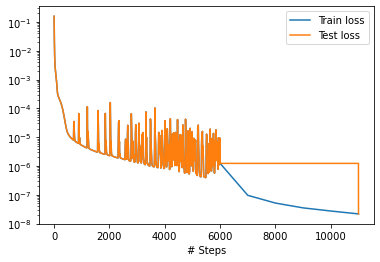

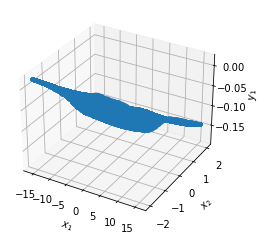

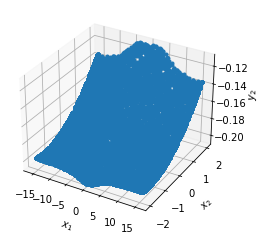

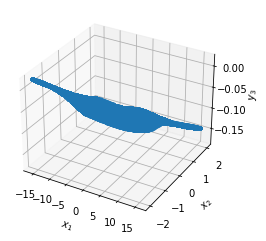

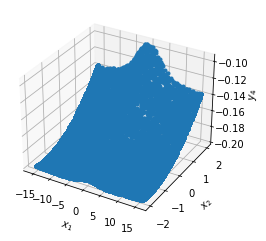

In [23]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-09,
    maxiter=20000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
# model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


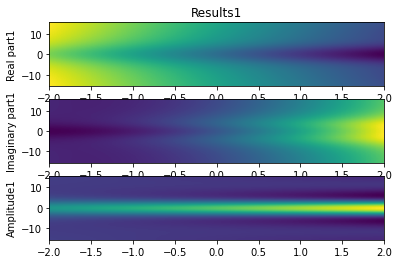

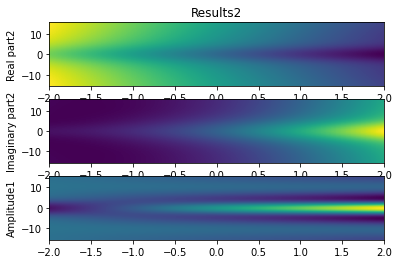

In [24]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2 = np.sqrt(u2**2+v2**2)


# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest",  # 插值
    cmap="viridis",  # 色彩图
    extent=[t_lower, t_upper, x_lower, x_upper],  # 极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest",  # 插值
    cmap="viridis",  # 色彩图
    extent=[t_lower, t_upper, x_lower, x_upper],  # 极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()


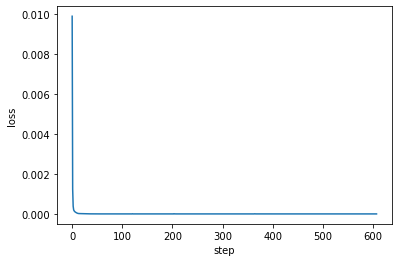

In [25]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

[0.17436324 0.17438586 0.17439194 ... 0.11051706 0.11045907 0.11045038]


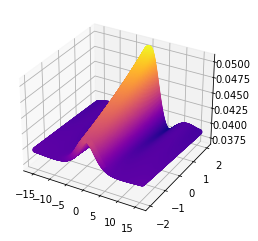

In [26]:
ax = plt.axes(projection='3d')


b = prediction[:, 0]**2+prediction[:, 1]**2
mm=min(b)
c = max(b)-min(b)
d = (b-mm)/c
#d = d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:, 0], X_star[:, 1], b, c=d[:], cmap='plasma')


[0.36291987 0.362946   0.36297464 ... 0.20633356 0.20630741 0.20638017]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


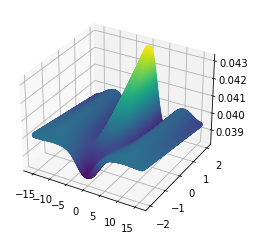

In [27]:
bx = plt.axes(projection='3d')
b = prediction[:, 2]**2+prediction[:, 3]**2
mm=min(b)
c = max(b)-min(b)
d = (b-mm)/c
#d = d.astype(int)
print(d)
bx.scatter3D(X_star[:, 0], X_star[:, 1], b, c=d[:])

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)
